<a href="https://colab.research.google.com/github/jjschueder/7331DataMiningNotebooks/blob/master/lab3/RF_with_cluster_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')
data = pd.read_csv("/content/drive/My Drive/ColabNotebooks/tnsefmergedf.csv", nrows = 40000)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
url_rfmodel = '/content/drive/My Drive/ColabNotebooks/rfmodelbasecluster.joblib'
#exporting model to drive
from joblib import dump, load
#dump(clf, url_rfmodel)

#importing model to new model name
clf = load(url_rfmodel)

In [0]:
data

,Unnamed: 0,Unnamed: 0.1,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,counter,liquor_category,store_parent,month,year,monthyear,sale_dollars_trans,cost_per_liter,cost_per_liter_trans,state_bottle_cost_trans,bottles_sold_trans,volume_sold_liters_trans,id_label,profit,profit_trans,totalcost,totalcost_trans,revenue,revenue_trans,bottle_volume_ml_trans,pack_trans,Cluster_Label
0,0,0,INV-23084400002,2019-11-07,3869,BOOTLEGGIN' BARZINI'S FIN,412 1st Ave,Coralville,52241.0,POINT (-91.565517 41.672672),52.0,JOHNSON,1092100.0,IMPORTED DISTILLED SPIRIT SPECIALTY,293,JINRO AMERICA INC,989215,JINRO CHAMISUL GRAPEFRUIT SOJU,20,375,3.85,5.78,20.0,115.60,7.50,1.98,1.0,Other,Other,Nov,2019,Nov-2019,4.750136,15.413333,2.735233,1.348073,2.995732,2.014903,1,38.60,3.653252,77.00,4.343805,115.60,4.750136,5.926926,2.995732,0
1,1,1,INV-23282200001,2019-11-18,4617,LICKETY LIQUOR,2501 HUBBELL AVE,Des Moines,50317.0,POINT (-93.570489 41.607817),77.0,POLK,1091300.0,NEUTRAL GRAIN SPIRITS FLAVORED,346,OLE SMOKY DISTILLERY LLC,86739,OLE SMOKY APPLE PIE MOONSHINE 70PRF MINI,8,50,8.75,13.13,1.0,13.13,0.05,0.01,1.0,Other,Other,Nov,2019,Nov-2019,2.574900,262.600000,5.570632,2.169054,0.000000,-2.995732,1,4.38,1.477049,8.75,2.169054,13.13,2.574900,3.912023,2.079442,1
2,2,2,INV-19435800130,2019-05-17,2560,HY-VEE FOOD STORE / MARION,3600 Business Hwy 151 East,Marion,52302.0,blank,57.0,LINN,1042100.0,IMPORTED DRY GINS,35,BACARDI USA INC,28233,BOMBAY SAPPHIRE GIN,12,1000,16.50,24.75,6.0,148.50,6.00,1.58,1.0,GIN,Hy-Vee,May,2019,May-2019,5.000585,24.750000,3.208825,2.803360,1.791759,1.791759,2,49.50,3.901973,99.00,4.595120,148.50,5.000585,6.907755,2.484907,2
3,3,3,INV-23454200002,2019-11-25,2614,HY-VEE #3 FOOD & DRUGSTORE / DAVENPORT,1823 E Kimberly Rd,Davenport,52807.0,POINT (-90.548919 41.55678100000001),82.0,SCOTT,1011300.0,SINGLE BARREL BOURBON WHISKIES,184,FOUR ROSES DISTILLERY,18350,FOUR ROSES SINGLE BARREL,6,750,21.17,31.76,24.0,762.24,18.00,4.75,1.0,WHISKY,Hy-Vee,Nov,2019,Nov-2019,6.636261,42.346667,3.745890,3.052585,3.178054,2.890372,3,254.16,5.537964,508.08,6.230639,762.24,6.636261,6.620073,1.791759,3
4,4,4,INV-23541200001,2019-11-27,2629,HY-VEE FOOD STORE #2 / COUNCIL BLUFFS,1745 Madison Ave,Council Bluffs,51503.0,POINT (-95.825137 41.242732),78.0,POTTAWATTA,1901200.0,SPECIAL ORDER ITEMS,285,Charles Jacquin Et Cie,902291,SOOH BARTENDERS BANANAS OVER YOU,6,1750,9.31,13.97,12.0,167.64,21.00,5.54,1.0,Other,Hy-Vee,Nov,2019,Nov-2019,5.121819,7.982857,2.077296,2.231089,2.484907,3.044522,1,55.92,4.023922,111.72,4.715996,167.64,5.121819,7.467371,1.791759,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,39995,INV-19064600027,2019-04-30,4097,SCHLESWIG FOODS AND SPIRITS,108 2nd St,Schleswig,51461.0,POINT (-95.436648 42.165983),24.0,CRAWFORD,1.0816e+06,WHISKEY LIQUEUR,421,SAZERAC COMPANY INC,86887,SOUTHERN COMFORT,12,1000,12.97,19.46,2.0,38.92,2.00,0.52,1.0,LIQUEUR,Other,Apr,2019,Apr-2019,3.661508,19.460000,2.968361,2.562639,0.693147,0.693147,5,12.98,2.563410,25.94,3.255786,38.92,3.661508,6.907755,2.484907,703
39996,39996,39996,INV-21943100003,2019-09-17,4638,GD XPRESS / DAVENPORT,4607 N Pine St,Davenport,52804.0,blank,82.0,SCOTT,1.0816e+06,WHISKEY LIQUEUR,421,SAZERAC COMPANY INC,86883,SOUTHERN COMFORT,48,200,2.64,3.96,48.0,190.08,9.60,2.53,1.0,LIQUEUR,Other,Sep,2019,Sep-2019,5.247445,19.800000,2.985682,0.970779,3.871201,2.261763,5,63.36,4.148833,126.72,4.841980,190.08,5.247445,5.298317,3.871201,185
39997,39997,39997,INV-22120200011,2019-09-24,5083,CENTRAL MART,"1203, Tri View Ave",Sioux City,51104.0,POINT (-96.422992 42.494265),97.0,WOODBURY,1.08

In [0]:

%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['sale_dollars_trans', 'cost_per_liter_trans', 
       'state_bottle_cost_trans', 'bottles_sold_trans',
       'volume_sold_liters_trans', 'pack_trans', 'bottle_volume_ml_trans',
       'profit_trans', 'totalcost_trans', 'revenue_trans', 'Cluster_Label']

X2 = data[features].copy()

scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)

Y= data[['id_label']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
#cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

CPU times: user 16.8 ms, sys: 497 µs, total: 17.3 ms
Wall time: 17.1 ms


In [0]:
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit
# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.2, random_state = 101)

In [0]:
clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [0]:
from sklearn.model_selection import cross_val_score

RF_accuracy = cross_val_score(clf, X, y=Y2, cv=cv)
RF_acc=RF_accuracy.mean()
print('Average RF accuracy score is : {}' .format(RF_acc))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Average RF accuracy score is : 0.651925


In [0]:
RF_accuracy

array([0.65775, 0.822  , 0.76925, 0.46575, 0.73575, 0.696  , 0.63525,
       0.7285 , 0.57775, 0.43125])

In [0]:
 for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     clf.fit(X_train, y_train)
     y_pred = clf.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 0  ====
accuracy 0.65775
confusion matrix
 [[ 131    2   13    3   29   42   18    1    0]
 [   3  145    2    0    1   21    0    0    0]
 [  38   57  684    1   14  107    3    0    0]
 [  25    1   71   87   33   11   56    1    0]
 [  56   47   24    0  213  168   28    0    0]
 [  33    4   20    6   11 1209   28    0    0]
 [  53   26  187   10   50   65  161    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 1  ====
accuracy 0.822
confusion matrix
 [[ 113    5   70    1   18   22   10    0    0]
 [   1  113   15    1   15   27    0    0    0]
 [  16   22  844    2    4    2   14    0    0]
 [   0    0    0  274    1    7    3    0    0]
 [   1    0    2    0  400   82   40   11    0]
 [   4    0    5    0   19 1269   14    0    0]
 [  39    6   43   26  136   28  274    0    0]
 [   0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 2  ====
accuracy 0.76925
confusion matrix
 [[ 122    0   64   12   11   21    9    0]
 [   2  101   16    0   41   10    1    0]
 [  49   15  813    0    1    1   24    2]
 [   0    0    0  282    0    3    0    0]
 [  23   33    6    1  317  144   12    0]
 [  21    4    0   15   47 1210   14    0]
 [  67    0    7   97   17  133  231    0]
 [   0    0    0    0    0    0    0    1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 3  ====
accuracy 0.46575
confusion matrix
 [[ 46  14  84   1  23  57  14   0   0]
 [ 13  83  25   1  19  27   3   0   0]
 [ 31   3 841   2   1   2  25   0   0]
 [  0   0  11 232   8  31   3   0   0]
 [ 12  33  23   0  62 390  16   0   0]
 [741   0   4  10  55 177 324   0   0]
 [  4   0  19   5  33  69 421   0   0]
 [  1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 4  ====
accuracy 0.73575
confusion matrix
 [[ 98  23  84   3   8   3  20   0   0   0]
 [  1 134   1   0   0  34   1   0   0   0]
 [ 47  15 824   1   1   7   9   0   1   0]
 [  0   0   0 285   0   0   0   0   0   0]
 [ 36   6  23   1 415  24  31   0   0   0]
 [119   5  29  10  90 809 246   0   0   3]
 [  8   0  17   1  42 106 377   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 5  ====
accuracy 0.696
confusion matrix
 [[ 150    3   42    4   14   13   13    0]
 [   0   73   24    0   42   32    0    0]
 [  62   40  593    0    3  173   34    0]
 [  16    0   50  163    0   50    6    0]
 [  29    3  155    1  264   34   50    0]
 [  11    4    1    2   17 1258   18    0]
 [   3    0   64    0   77  126  281    0]
 [   0    0    0    0    0    0    0    2]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 6  ====
accuracy 0.63525
confusion matrix
 [[ 120   11   72    0    3   12   20    0]
 [   2   69   23    0   50   24    4    0]
 [  41   48  544    0   32   92  148    0]
 [  60   35    6   48   24   77   35    0]
 [  82   12   46    0  202  156   38    0]
 [   6   32   34    4  123 1052   60    0]
 [   5    0    0    0   27   15  504    0]
 [   0    0    0    0    0    0    0    2]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 7  ====
accuracy 0.7285
confusion matrix
 [[ 124    0    7   20    1   40   46    0    0]
 [  27  118   21    1    0    4    1    0    0]
 [  21   73  633   43   13   69   52    0    0]
 [   1    0    0  282    0    3    0    0    0]
 [  37    6   58   30  121  273   11    0    0]
 [   2   31   18    4    8 1247    1    0    0]
 [   9    0   94    0   50   11  387    0    0]
 [   0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    0    0    0    0    1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 8  ====
accuracy 0.57775
confusion matrix
 [[187   0   1   6   0   7  37   0   0]
 [ 15  73  38   1  20  16   9   0   0]
 [ 50  65 510 111  64  16  88   0   0]
 [ 20   0   0 224   2  20  20   0   0]
 [  0   5   2   1 486   7  35   0   0]
 [ 37 220 151  24 304 487  87   0   0]
 [166   0   1   9   1  33 342   0   0]
 [  0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


====Iteration 9  ====
accuracy 0.43125
confusion matrix
 [[ 66   0  14  31   1  94  32   0   0]
 [ 27  10  71   5  34   8  17   0   0]
 [124   0 575   0   7 116  82   0   0]
 [  9   0   1 107  13 156   0   0   0]
 [  0   0   0   1 477  15  43   0   0]
 [ 76  80 832   9 102 145  66   0   0]
 [134   0   5   9   5  55 344   0   0]
 [  0   0   0   0   0   0   0   1   0]
 [  1   0   0   0   0   0   0   0   0]]


In [0]:
clf.fit(X1_train, y1_train)
y_pred = clf.predict(X1_test)
conf = mt.confusion_matrix(y1_test,y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# source of code: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Accuracy: 0.921125


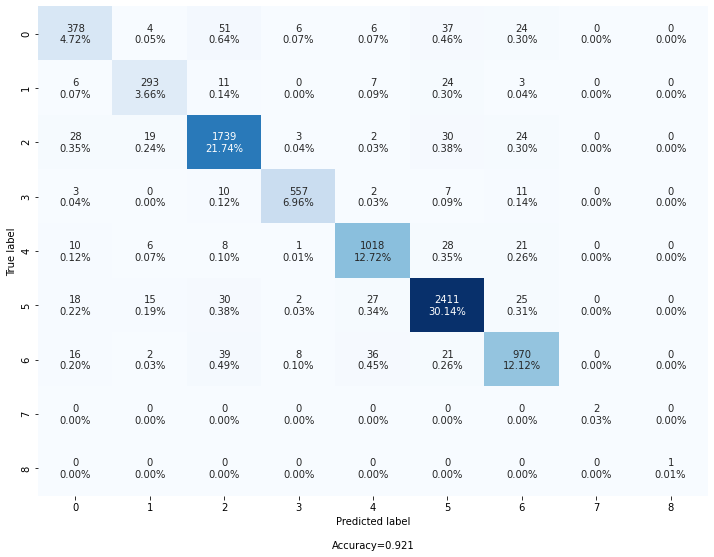

In [0]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y1_test,y_pred))
matrix = confusion_matrix(y1_test,y_pred)
make_confusion_matrix(matrix, figsize=(12,9), cbar=False)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score is: {}" .format(precision_score(y1_test,y_pred, average='weighted')))
print("Recall Score is: {}" .format(recall_score(y1_test,y_pred, average='weighted')))
print("F1 Score is: {}" .format(f1_score(y1_test,y_pred, average='weighted')))

Precision Score is: 0.920466114002605
Recall Score is: 0.921125
F1 Score is: 0.9206220499197816


In [0]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14

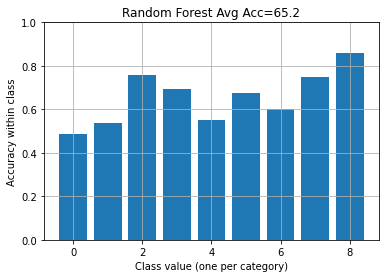

In [0]:
totalacc = 0
totalprec = 0
totalrec= 0
totalf1  = 0
listx = []
perclasslist = []
for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
#     sm = SMOTE(random_state=101)
#     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     clf.fit(X_train, y_train) 
     y_pred = clf.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     prec = precision_score(y_test, y_pred, average='weighted')
     rec = recall_score(y_test, y_pred, average='weighted')
     f1 = f1_score(y_test, y_pred, average='weighted')
     perclassaccuracy = per_class_accuracy(y_test,y_pred)
     perclasslist.append(perclassaccuracy.tolist())
     totalacc += acc
     totalprec += prec
     totalrec += rec
     totalf1 += f1
     conf = mt.confusion_matrix(y_test,y_pred)
#     print("Sum: ", totalacc, "Current: ", acc,"Per Class",perclassaccuracy,"\n")


avgaccuracy = 100*totalacc / cv.n_splits
avgprec = 100*totalprec / cv.n_splits
avgrec = 100*totalrec / cv.n_splits
avgf1 = 100*totalf1 / cv.n_splits
 

listx.append(("Model 2", "Random Forest", avgaccuracy, avgprec, avgrec, avgf1))

perclassdf = []
perclassdf = pd.DataFrame(perclasslist)
#perclassdf = perclassdf.transpose()
#perclassdf

perclassavg = perclassdf.mean(axis = 0) 
#perclassavg

plt.bar(range(len(perclassavg)), perclassavg)
plt.xlabel('Class value (one per category)')
plt.ylabel('Accuracy within class')
#plt.title(title+", Total Acc=%.1f"%(totalaccuracy))
plt.title("Random Forest Avg Acc=%.1f"%(avgaccuracy))
plt.grid()
plt.ylim([0,1])
plt.show()

In [0]:
listx

[('Model 2',
  'Random Forest',
  65.19250000000001,
  66.2888940471183,
  65.19250000000001,
  63.88509642776014)]

In [0]:
dfobj = pd.DataFrame(listx, columns = ['Model Number', 'Model','Accuracy' , 'Precision', 'Recall', 'F1'], index=['0', '1', '2'])
dfobj

,Model Number,Model,Accuracy,Precision,Recall,F1
0,Model 2,Random Forest,65.1925,66.288894,65.1925,63.885096
1,Model 2,Random Forest,65.1925,66.288894,65.1925,63.885096
2,Model 2,Random Forest,65.1925,66.288894,65.1925,63.885096


In [0]:
ylist = Y['id_label'].values.astype('int64')
ylist
ylist.shape

(40000,)

In [0]:
from sklearn.preprocessing import label_binarize
ybinary = label_binarize(ylist, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = ybinary.shape[1]
X_train4, X_test4, y_train4, y_test4 = train_test_split(X,ybinary, test_size=0.2) # 70% training and 30% test

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve

In [0]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier

In [0]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_predict
# Learn to predict each class against the other
rfclassifiercv = OneVsRestClassifier(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False))
rfbinarymodel = rfclassifiercv.fit(X_train4, y_train4)
rfbinaryscore = rfclassifiercv.predict(X_test4)
y_score = cross_val_predict(rfclassifiercv, X, ybinary, cv=10 ,method='predict_proba')

CPU times: user 25min 48s, sys: 9.66 s, total: 25min 58s
Wall time: 26min 2s


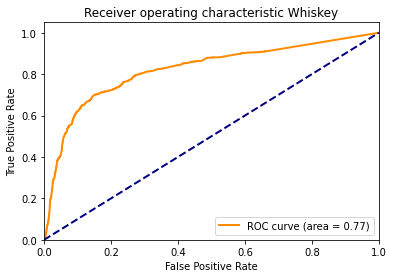

In [0]:
#X1_train, X1_test, y1_train, y1_test
#y_score = classifier.fit(X_train3, y_train3).decision_function(X_test3)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ybinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ybinary.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#Plot of a ROC curve for a specific class

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Whiskey')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


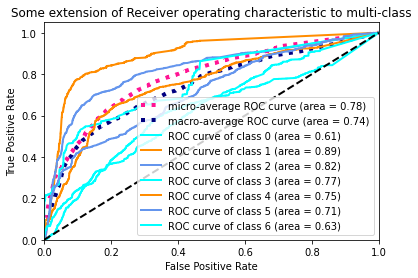

In [0]:
roc_list =[]
from scipy import interp
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_list.append(("Model 2", "RF", roc_auc["macro"],fpr["macro"],tpr["macro"]))
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [0]:
dfroc = pd.DataFrame(roc_list, columns = ['Model Number', 'Model', 'ROC', "fpr", "tpr"], index=['0', '1', '2'])
dfroc

,Model Number,Model,ROC,fpr,tpr
0,Model 2,RF,0.740644,"[0.0, 2.6920074299405065e-05, 5.31716913915031...","[0.012487679641767235, 0.01529822203608446, 0...."
1,Model 2,RF,0.740644,"[0.0, 2.6920074299405065e-05, 5.31716913915031...","[0.012487679641767235, 0.01529822203608446, 0...."
2,Model 2,RF,0.740644,"[0.0, 2.6920074299405065e-05, 5.31716913915031...","[0.012487679641767235, 0.01529822203608446, 0...."
